In [1]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re 
import seaborn as sns
import nltk
# nltk.download()
%matplotlib inline

In [2]:
# !pip install -U nltk

In [2]:
url = 'http://www.prosportstransactions.com/basketball/Search/SearchResults.php?Player=&Team=&BeginDate=&EndDate=&InjuriesChkBx=yes&Submit=Search&start=27525'
html = urlopen(url)
soup = BeautifulSoup(html, 'html.parser')

In [103]:
#the html goes up in increments of 25, so need to multiply the page number by 25 (minus 25)
#For example page 1103 becomes (1103*25)-25 = 27550
full_injury_data = pd.DataFrame()
for i in range(891, 1105):
    html_num = (i*25)-25
    url = 'http://www.prosportstransactions.com/basketball/Search/SearchResults.php?Player=&Team=&BeginDate=&EndDate=&InjuriesChkBx=yes&Submit=Search&start={}'.format(html_num)
    html = urlopen(url)
    soup = BeautifulSoup(html, 'html.parser')
    column_headers = [th.getText().replace(u'\xa0', u'') for th in
                  soup.findAll('tr', limit=1)[0].findAll('td')[0:]]
    data_rows = soup.findAll('tr')[1:26]
    player_data = [[td.getText().replace(u' • ', u'') for td in data_rows[i].findAll('td')]
                for i in range(len(data_rows))]
    #Create an empty list to fill up with the data from each row
    player_data_02 = []
    for j in range(len(data_rows)):  # for each table row
        player_row = []  # create an empty list for each player

        # for each table data element from each table row
        for td in data_rows[j].findAll('td'):
            # get the text content and append to the player_row
            player_row.append(td.getText())
    df = pd.DataFrame(player_data, columns=column_headers)
    full_injury_data = full_injury_data.append(df, ignore_index=True)

#     df = pd.DataFrame(player_data, columns=column_headers)
#     full_injury_data = full_injury_data.append(df, ignore_index=True)
full_injury_data.head()

,Date,Team,Acquired,Relinquished,Notes
0,2014-04-30,Mavericks,,Gal Mekel,knee injury (DNP)
1,2014-05-01,Warriors,,Andrew Bogut,fractured right rib (DNP)
2,2014-05-02,Bulls,,Joakim Noah,arthroscopic surgery on left knee (out indefi...
3,2014-05-02,Mavericks,,Gal Mekel,knee injury (DNP)
4,2014-05-03,Warriors,,Andrew Bogut,fractured right rib (DNP)


In [105]:
# full_injury_data.to_csv('full_injury_data.csv', index=False)

In [2]:
full_injury_data = pd.read_csv('full_injury_data.csv')

In [3]:
full_injury_data[(full_injury_data['Acquired']=='John Wall (a)') |
                 (full_injury_data['Relinquished']=='John Wall (a)')]

,Date,Team,Acquired,Relinquished,Notes
1061,2015-04-15,Wizards,,John Wall (a),rest (DTD)
1069,2015-04-18,Wizards,John Wall (a),,returned to lineup
2346,2016-05-05,Wizards,,John Wall (a),surgery on left knee to remove calcium deposi...
3524,2017-04-10,Wizards,,John Wall (a),rest / quadriceps injury (DTD)
3570,2017-04-12,Wizards,,John Wall (a),rest (DTD)
3584,2017-04-16,Wizards,John Wall (a),,returned to lineup
3775,2017-11-19,Wizards,,John Wall (a),sore left knee / left knee inflammation (DTD)
3780,2017-11-20,Wizards,John Wall (a),,returned to lineup
4171,2018-01-31,Wizards,,John Wall (a),arthroscopic surgery on left knee (out indefi...
4482,2018-04-01,Wizards,,John Wall (a),rest (DTD)


In [5]:
full_injury_data.head()

,Date,Team,Acquired,Relinquished,Notes
0,2014-04-30,Mavericks,,Gal Mekel,knee injury (DNP)
1,2014-05-01,Warriors,,Andrew Bogut,fractured right rib (DNP)
2,2014-05-02,Bulls,,Joakim Noah,arthroscopic surgery on left knee (out indefi...
3,2014-05-02,Mavericks,,Gal Mekel,knee injury (DNP)
4,2014-05-03,Warriors,,Andrew Bogut,fractured right rib (DNP)


In [4]:
#Clean up the names (some have brackets etc.) 
full_injury_data['full_name_raw'] = full_injury_data['Acquired'] + full_injury_data['Relinquished']
#Get rid of the leading space and trailing space.
full_injury_data['full_name_raw'] = full_injury_data['full_name_raw'].apply(
    lambda x: x.lstrip().rstrip())
full_injury_data['Notes'] = full_injury_data['Notes'].apply(
    lambda x: x.lstrip().rstrip())
#First full name
full_injury_data['full_name_main'] = full_injury_data['full_name_raw'].apply(
    lambda x: x.split('/ ')[0] if len(x.split('/'))==2 else x)
#Some have 2 full names separated by a slash - create an alternate name field
full_injury_data['full_name_alt'] = full_injury_data['full_name_raw'].apply(
    lambda x: x.split('/ ')[1] if len(x.split('/'))==2 else '')
#Some names have brackets so extract the text from this into a new bracket column
full_injury_data['full_name_brack'] = full_injury_data['full_name_raw'].apply(
    lambda x:  re.search(r'\((.*?)\)', x).group()[1:].replace(')', '') if re.search(r'\((.*?)\)', x) else '')
#Get rid of the bracketted part of name if it exists in the main name
full_injury_data['full_name_main'] = full_injury_data['full_name_main'].apply(
    lambda x:  re.sub('\((.*?)\)', '', x).lstrip().rstrip())
#Get rid of lines in the date for 'returned to lineup' - we will use game logs for this instead
full_injury_data = full_injury_data[full_injury_data['Notes']!='returned to lineup']
#Make the date column date type
full_injury_data['Date'] = pd.to_datetime(full_injury_data['Date'])

In [5]:
#Bunch of random bracketted names
full_injury_data.Notes.unique()

array(['knee injury (DNP)', 'fractured right rib (DNP)',
       'arthroscopic surgery on left knee (out indefinitely)', ...,
       'right knee injury (out indefinitely',
       'neck injury (out indefinitely)', 'toe injury (out for season)'],
      dtype=object)

In [6]:
full_injury_data[full_injury_data['full_name_main']=='John Wall'].head()

,Date,Team,Acquired,Relinquished,Notes,full_name_raw,full_name_main,full_name_alt,full_name_brack
1061,2015-04-15,Wizards,,John Wall (a),rest (DTD),John Wall (a),John Wall,,a
2346,2016-05-05,Wizards,,John Wall (a),surgery on left knee to remove calcium deposit...,John Wall (a),John Wall,,a
3524,2017-04-10,Wizards,,John Wall (a),rest / quadriceps injury (DTD),John Wall (a),John Wall,,a
3570,2017-04-12,Wizards,,John Wall (a),rest (DTD),John Wall (a),John Wall,,a
3775,2017-11-19,Wizards,,John Wall (a),sore left knee / left knee inflammation (DTD),John Wall (a),John Wall,,a


In [7]:
#Extract the injury type and classification (surgery / DTD / indefinitely etc.)
full_injury_data['injury_class'] = full_injury_data['Notes'].apply(
    lambda x:  re.search(r'\((.*?)\)', x).group()[1:].replace(')', '') if re.search(r'\((.*?)\)', x) else '')

In [8]:
full_injury_data['injury_class'].unique()

array(['DNP', 'out indefinitely', 'DTD', 'surgery', 'out for season', '',
       'P', 'effective at the end of the season', 'date approximate',
       'eyelid', 'did not miss any games', 'from gunshot wound', 'Y',
       'left game', 'already on IL', 'off court injury', 'CBC', 'CBC Y',
       'P Y', 'blood disorder', 'out for seaon', 'out indefinitley',
       'out'], dtype=object)

In [9]:
full_injury_data.groupby(['injury_class']).size()

injury_class
                                        43
CBC                                      6
CBC Y                                    1
DNP                                     26
DTD                                   2701
P                                        9
P Y                                      1
Y                                        1
already on IL                            1
blood disorder                           1
date approximate                         6
did not miss any games                   1
effective at the end of the season       1
eyelid                                   1
from gunshot wound                       1
left game                                1
off court injury                         1
out                                      1
out for seaon                            1
out for season                         349
out indefinitely                       299
out indefinitley                         1
surgery                                  

In [10]:
full_injury_data[full_injury_data['injury_class']=='from gunshot wound']

,Date,Team,Acquired,Relinquished,Notes,full_name_raw,full_name_main,full_name_alt,full_name_brack,injury_class
1494,2015-12-30,Knicks,,Cleanthony Early,knee injury (from gunshot wound) (DTD),Cleanthony Early,Cleanthony Early,,,from gunshot wound


In [11]:
#Filter out stopwords with nltk package
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


In [12]:
from nltk.tokenize import word_tokenize
tokens = word_tokenize('surgery on left knee to remove calcium deposit')
words = [word for word in tokens if word.isalpha()]
words = [w for w in words if not w in stop_words]
' '.join(words)

'surgery left knee remove calcium deposit'

In [13]:
#Function to clean Notes string
def clean_injury_notes(x):
    #remove bracketted words
    x = re.sub('\((.*?)\)', '', x).lstrip().rstrip()
    #tokenize string
    tokens = word_tokenize(x)
    words = [word for word in tokens if word.isalpha()]
    words = [w for w in words if not w in stop_words]
    return_x = ' '.join(words)
    return(return_x)
clean_injury_notes('surgery on left knee to remove calcium deposit')

'surgery left knee remove calcium deposit'

In [14]:
#Clean up injury notes
full_injury_data['notes_clean'] = full_injury_data['Notes'].apply(lambda x: clean_injury_notes(x))

In [15]:
full_injury_data[full_injury_data['full_name_main']=='John Wall'].head()

,Date,Team,Acquired,Relinquished,Notes,full_name_raw,full_name_main,full_name_alt,full_name_brack,injury_class,notes_clean
1061,2015-04-15,Wizards,,John Wall (a),rest (DTD),John Wall (a),John Wall,,a,DTD,rest
2346,2016-05-05,Wizards,,John Wall (a),surgery on left knee to remove calcium deposit...,John Wall (a),John Wall,,a,out indefinitely,surgery left knee remove calcium deposits
3524,2017-04-10,Wizards,,John Wall (a),rest / quadriceps injury (DTD),John Wall (a),John Wall,,a,DTD,rest quadriceps injury
3570,2017-04-12,Wizards,,John Wall (a),rest (DTD),John Wall (a),John Wall,,a,DTD,rest
3775,2017-11-19,Wizards,,John Wall (a),sore left knee / left knee inflammation (DTD),John Wall (a),John Wall,,a,DTD,sore left knee left knee inflammation


In [16]:
#There are 804 unique strings for this field.
#We should group this further.
full_injury_data.groupby(['notes_clean']).size().sort_values(ascending=False)

notes_clean
rest                                                               301
illness                                                            185
sprained left ankle                                                173
sprained right ankle                                               144
sore right knee                                                     88
sore left knee                                                      87
concussion                                                          61
back spasms                                                         43
back injury                                                         41
left knee injury                                                    39
sore lower back                                                     39
ankle injury                                                        34
knee injury                                                         34
strained left hamstring                                          

In [17]:
#We may aswell shrink the text to remove the words 'right / left / upper / lower', 'injury', 'surgery'.
#We will store 'right / left / upper / lower' as flags aswell as 'surgery'. This should shrink most of the text to 
#the actual part of the body that's injured
full_injury_data['injury_position_left'] = full_injury_data['notes_clean'].apply(
    lambda x: 1 if re.search(r'left', x) else 0)
full_injury_data[full_injury_data['injury_position_left']==1]
full_injury_data['injury_position_right'] = full_injury_data['notes_clean'].apply(
    lambda x: 1 if re.search(r'right', x) else 0)
full_injury_data['injury_position_upper'] = full_injury_data['notes_clean'].apply(
    lambda x: 1 if re.search(r'upper', x) else 0)
full_injury_data['injury_position_lower'] = full_injury_data['notes_clean'].apply(
    lambda x: 1 if re.search(r'lower', x) else 0)
full_injury_data['injury_surgery'] = full_injury_data['notes_clean'].apply(
    lambda x: 1 if re.search(r'surgery', x) else 0)
#Strained / sprained / sore?
full_injury_data['injury_strained'] = full_injury_data['notes_clean'].apply(
    lambda x: 1 if re.search(r'strained', x) else 0)
full_injury_data['injury_sprained'] = full_injury_data['notes_clean'].apply(
    lambda x: 1 if re.search(r'sprained', x) else 0)
full_injury_data['injury_sore'] = full_injury_data['notes_clean'].apply(
    lambda x: 1 if re.search(r'sore', x) else 0)

#Strip out words : right / left / upper / lower / surgery / injury
full_injury_data['injury_details'] = full_injury_data['notes_clean'].apply(
    lambda x: re.sub('  ', ' ', re.sub(r'right|left|upper|lower|surgery|injury','', x).lstrip().rstrip()))
#Strip out all adjectives
adj = 'right|left|upper|lower|surgery|injury|strained|sprained|sore|arthroscopic|fractured|bruised|torn'
full_injury_data['injury_anat'] = full_injury_data['notes_clean'].apply(
    lambda x: re.sub('  ', ' ', re.sub(adj,'', x).lstrip().rstrip()))
full_injury_data.head()


,Date,Team,Acquired,Relinquished,Notes,full_name_raw,full_name_main,full_name_alt,full_name_brack,injury_class,...,injury_position_left,injury_position_right,injury_position_upper,injury_position_lower,injury_surgery,injury_strained,injury_sprained,injury_sore,injury_details,injury_anat
0,2014-04-30,Mavericks,,Gal Mekel,knee injury (DNP),Gal Mekel,Gal Mekel,,,DNP,...,0,0,0,0,0,0,0,0,knee,knee
1,2014-05-01,Warriors,,Andrew Bogut,fractured right rib (DNP),Andrew Bogut,Andrew Bogut,,,DNP,...,0,1,0,0,0,0,0,0,fractured rib,rib
2,2014-05-02,Bulls,,Joakim Noah,arthroscopic surgery on left knee (out indefin...,Joakim Noah,Joakim Noah,,,out indefinitely,...,1,0,0,0,1,0,0,0,arthroscopic knee,knee
3,2014-05-02,Mavericks,,Gal Mekel,knee injury (DNP),Gal Mekel,Gal Mekel,,,DNP,...,0,0,0,0,0,0,0,0,knee,knee
4,2014-05-03,Warriors,,Andrew Bogut,fractured right rib (DNP),Andrew Bogut,Andrew Bogut,,,DNP,...,0,1,0,0,0,0,0,0,fractured rib,rib


In [18]:
#There are 804 unique strings for this field.
#We should group this further.
full_injury_data['injury_class'].unique()
pd.set_option('display.max_rows', 500)
full_injury_data.groupby(['injury_class']).count()
#Pretty much all are classified as DTD, Out indefinitely, and Out for season 

,Date,Team,Acquired,Relinquished,Notes,full_name_raw,full_name_main,full_name_alt,full_name_brack,notes_clean,injury_position_left,injury_position_right,injury_position_upper,injury_position_lower,injury_surgery,injury_strained,injury_sprained,injury_sore,injury_details,injury_anat
injury_class,,,,,,,,,,,,,,,,,,,,
,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43
CBC,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
CBC Y,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
DNP,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26
DTD,2701,2701,2701,2701,2701,2701,2701,2701,2701,2701,2701,2701,2701,2701,2701,2701,2701,2701,2701,2701
P,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
P Y,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Y,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
already on IL,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [19]:
full_injury_data[full_injury_data['injury_class'].isin(
    ['out indefinitely', 'out for season', 'DTD'])].groupby(
    ['injury_class','injury_anat']).count()
#It looks like we could group these injuries mostly by the first word

Date  \
injury_class     injury_anat                                                
DTD                                                                     7   
                 AC joint shoulder                                      1   
                 ACL knee                                               1   
                 Achilles                                              32   
                 Achilles tendinitis                                    2   
                 Achilles tendon                                        6   
                 MCL knee                                               8   
                 SC joint collarbone                                    1   
                 abdomen oblique                                        1   
                 abdominal                                              6   
                 abdominal muscle                                       2   
                 abdominal sports hernia                                1   
                 abductor adductor                                      1   
                 adductor                                              16   
                 adductor muscle                                        1   
                 adductor muscle  hamstring                             1   
                 allergic reaction illness                              1   
                 ankle                                                410   
                 ankle  foot                                            1   
                 ankle Achilles tendinitis                              1   
                 ankle foot                                             2   
                 ankle impingement                                      1   
                 ankle inflammation                                     1   
                 ankle knee                                             2   
                 ankle remove bone fragment                             1   
                 ankle rest                                             1   
                 ankle tendinitis                                       2   
                 arm                                                    2   
                 axillary abscess                                       1   
                 back                                                 119   
                 back  side                                             1   
                 back SI joint                                          1   
                 back ankle                                             1   
                 back back spasms                                       2   
                 back hip                                               1   
                 back spasms                                           51   
                 back spasms  back                                      2   
                 back spasms back                                       1   
                 biceps tendinitis                                      1   
                 big toe                                               27   
                 big toe inflammation                                   1   
                 bone bruise                                            1   
                 bone bruise ankle                                      1   
                 bone bruise foot                                       2   
                 bone bruise knee                                      10   
                 bursitis ankle                                         2   
                 bursitis ankle calf                                    1   
                 bursitis heel                                          1   
                 bursitis knee                                          1   
                 calf                                                  56   
                 calf knee                                       

In [20]:
full_injury_data['injury_anat_partone'] = full_injury_data['injury_anat'].apply(
    lambda x: x.split()[0].strip() if x.split() else '')
injury_type_freq = full_injury_data[full_injury_data['injury_class'] \
    .isin(['out indefinitely', 'out for season', 'DTD'])] \
    .groupby(['injury_class','injury_anat_partone']) \
    .agg({'injury_anat_partone' : 'count'}) \
    .rename(columns={'injury_anat_partone': 'count'}) \
    .sort_values(['injury_class','count'], ascending=False).reset_index().groupby('injury_class') \
    .apply(lambda x: x.nlargest(10, 'count')).rename(columns={'injury_class' : 'injury_class2'}).reset_index()
injury_type_freq

,injury_class,level_1,injury_class2,injury_anat_partone,count
0,DTD,129,DTD,ankle,422
1,DTD,130,DTD,knee,342
2,DTD,131,DTD,rest,296
3,DTD,132,DTD,illness,181
4,DTD,133,DTD,back,179
5,DTD,134,DTD,hamstring,128
6,DTD,135,DTD,hip,89
7,DTD,136,DTD,foot,82
8,DTD,137,DTD,shoulder,82
9,DTD,138,DTD,calf,59


## Plot: Injury location by injury class
  
- knees, followed by ankles are the most common injury type.
- this doesn't differ across injury class
- We need to eventually find a way to group the same injury across different dates. (i.e. players get injured and then have surgery about a week later - this is sometimes two entries). Maybe if the injury name / location is the same then take the most recent data point.

C:\Users\miah.stewart\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


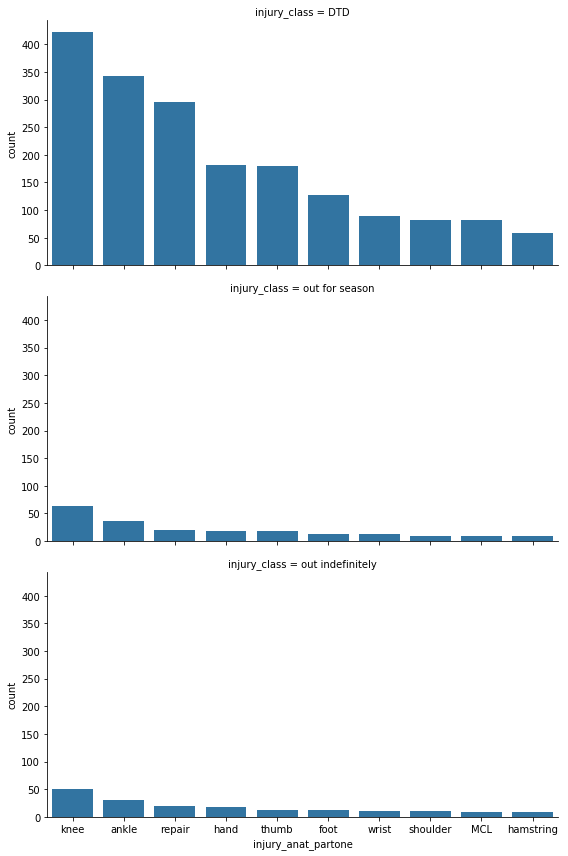

In [21]:
g = sns.FacetGrid(injury_type_freq, row="injury_class",
                  palette="Set3", size=4, aspect=2)
g.map(sns.barplot,'injury_anat_partone','count')

In [22]:
#We should treat injury rows on the same part of the body as the same injury - take the latter row and remove earlier.
#We need to create a function to incorporate this logic. We can use the player game log data to see whether the player
# played a game in between injuries - if they have, then we can regard the injury as new.
full_injury_data[full_injury_data['full_name_main']=='Kawhi Leonard'].head(15)

,Date,Team,Acquired,Relinquished,Notes,full_name_raw,full_name_main,full_name_alt,full_name_brack,injury_class,...,injury_position_right,injury_position_upper,injury_position_lower,injury_surgery,injury_strained,injury_sprained,injury_sore,injury_details,injury_anat,injury_anat_partone
271,2014-12-17,Spurs,,Kawhi Leonard,bruised right hand (DTD),Kawhi Leonard,Kawhi Leonard,,,DTD,...,1,0,0,0,0,0,0,bruised hand,hand,hand
1824,2016-02-18,Spurs,,Kawhi Leonard,tightness in left calf (DTD),Kawhi Leonard,Kawhi Leonard,,,DTD,...,0,0,0,0,0,0,0,tightness calf,tightness calf,tightness
2085,2016-03-23,Spurs,,Kawhi Leonard,bruised right quadriceps (DTD),Kawhi Leonard,Kawhi Leonard,,,DTD,...,1,0,0,0,0,0,0,bruised quadriceps,quadriceps,quadriceps
2227,2016-04-08,Spurs,,Kawhi Leonard,rest (DTD),Kawhi Leonard,Kawhi Leonard,,,DTD,...,0,0,0,0,0,0,0,rest,rest,rest
2307,2016-04-13,Spurs,,Kawhi Leonard,rest (DTD),Kawhi Leonard,Kawhi Leonard,,,DTD,...,0,0,0,0,0,0,0,rest,rest,rest
2823,2016-12-28,Spurs,,Kawhi Leonard,gastroenteritis (DTD),Kawhi Leonard,Kawhi Leonard,,,DTD,...,0,0,0,0,0,0,0,gastroenteritis,gastroenteritis,gastroenteritis
3018,2017-01-23,Spurs,,Kawhi Leonard,sore left hand (DTD),Kawhi Leonard,Kawhi Leonard,,,DTD,...,0,0,0,0,0,0,1,sore hand,hand,hand
3131,2017-02-06,Spurs,,Kawhi Leonard,bruised right quadriceps (DTD),Kawhi Leonard,Kawhi Leonard,,,DTD,...,1,0,0,0,0,0,0,bruised quadriceps,quadriceps,quadriceps
3271,2017-03-10,Spurs,,Kawhi Leonard,concussion (DTD),Kawhi Leonard,Kawhi Leonard,,,DTD,...,0,0,0,0,0,0,0,concussion,concussion,concussion
3480,2017-04-07,Spurs,,Kawhi Leonard,rest (DTD),Kawhi Leonard,Kawhi Leonard,,,DTD,...,0,0,0,0,0,0,0,rest,rest,rest


In [24]:
#Use list comprehension to split out each unique word from the column
unique_words = set([y for x in full_injury_data['injury_anat'].apply(lambda x: x.split()) for y in x])
# unique_words = set(full_injury_data['notes_clean'].apply(lambda x: x.split()))
unique_words
# for word in unique_words:
#     file.write(str(word) + "\n")

{'AC',
 'ACL',
 'Achilles',
 'DNP',
 'IL',
 'MCL',
 'NBA',
 'SC',
 'SI',
 'abdomen',
 'abdominal',
 'abductor',
 'abrasion',
 'abscess',
 'absence',
 'absense',
 'address',
 'adductor',
 'adnoids',
 'ailment',
 'air',
 'allergic',
 'ankle',
 'appendectomy',
 'appendix',
 'arm',
 'around',
 'arthrosopic',
 'athletic',
 'atrial',
 'axillary',
 'back',
 'biceps',
 'big',
 'blood',
 'bodies',
 'body',
 'bone',
 'bones',
 'bruise',
 'bursitis',
 'calcium',
 'calf',
 'cartilage',
 'cheek',
 'chest',
 'chip',
 'chips',
 'chondromalacia',
 'clots',
 'coach',
 'cold',
 'collapsed',
 'collarbone',
 'concussion',
 'contract',
 'contusion',
 'core',
 'cornea',
 'corneal',
 'cramps',
 'cuff',
 'damage',
 'debris',
 'declined',
 'dental',
 'deposits',
 'disc',
 'dislocated',
 'dislocation',
 'dizziness',
 'elbow',
 'embolism',
 'exercise',
 'exploratory',
 'extraction',
 'eye',
 'eyelid',
 'face',
 'facial',
 'faciitis',
 'fan',
 'fascia',
 'fasciitis',
 'fibula',
 'fined',
 'finger',
 'flexor',
 'f

In [25]:
full_injury_data.to_csv('full_injury_data_clean.csv', index=False)

In [26]:
full_injury_data.dtypes

Date                     datetime64[ns]
Team                             object
Acquired                         object
Relinquished                     object
Notes                            object
full_name_raw                    object
full_name_main                   object
full_name_alt                    object
full_name_brack                  object
injury_class                     object
notes_clean                      object
injury_position_left              int64
injury_position_right             int64
injury_position_upper             int64
injury_position_lower             int64
injury_surgery                    int64
injury_strained                   int64
injury_sprained                   int64
injury_sore                       int64
injury_details                   object
injury_anat                      object
injury_anat_partone              object
dtype: object